<a href="https://colab.research.google.com/github/budoorhza/PROJECT363/blob/main/1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import albumentations as A
from google.colab import drive
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from sklearn.utils.class_weight import compute_class_weight

In [20]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [21]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:

# نسخ الملف إلى مساحة العمل
!cp '/content/drive/MyDrive/363PROJECT/BrainTumorDataset.zip' /content/

# فك الضغط في مساحة العمل
import shutil
zip_path = '/content/BrainTumorDataset.zip'
extract_path = '/content/BrainTumorDataset'
shutil.unpack_archive(zip_path, extract_path)

In [23]:
print("Files in extracted folder:", os.listdir(extract_path))

Files in extracted folder: ['Training', 'Testing']


In [24]:
def load_data(main_dir, img_size=(128, 128)):
    images, masks = [], []
    classes = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}  # تصنيفات الفئات
    for category in classes.keys():
        category_path = os.path.join(main_dir, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, img_size)
            images.append(img)

            # إنشاء القناع
            mask = classes[category]
            masks.append(mask)

    images = np.array(images) / 255.0  # تطبيع الصور
    images = np.expand_dims(images, axis=-1)  # إضافة بُعد القناة
    masks = np.array(masks)  # تحويل الأقنعة إلى مصفوفة
    return images, masks

# مسارات المجلدات
training_dir = '/content/BrainTumorDataset/Training'
testing_dir = '/content/BrainTumorDataset/Testing'


# تحميل بيانات التدريب والاختبار
X_train, y_train = load_data(training_dir)
X_test, y_test = load_data(testing_dir)



In [28]:
print(X_train.shape, y_train.shape)

(5712, 128, 128, 1) (5712,)


In [29]:
# دالة لتحويل التصنيفات إلى أقنعة بكسلية
def create_pixel_masks(y, img_size=(128, 128), num_classes=4):
    masks = []
    for label in y:
        mask = np.zeros((img_size[0], img_size[1], num_classes))
        mask[..., int(label)] = 1  # تحويل الفئة إلى One-Hot
        masks.append(mask)
    return np.array(masks)

# إنشاء أقنعة بكسلية
y_train = create_pixel_masks(y_train, img_size=(128, 128), num_classes=4)
y_test = create_pixel_masks(y_test, img_size=(128, 128), num_classes=4)


In [42]:
print(np.unique(y_train[:10]))  # طباعة بعض القيم الأولى
print(np.unique(y_test[:10]))   # طباعة بعض القيم الأولى


[0. 1.]
[0. 1.]


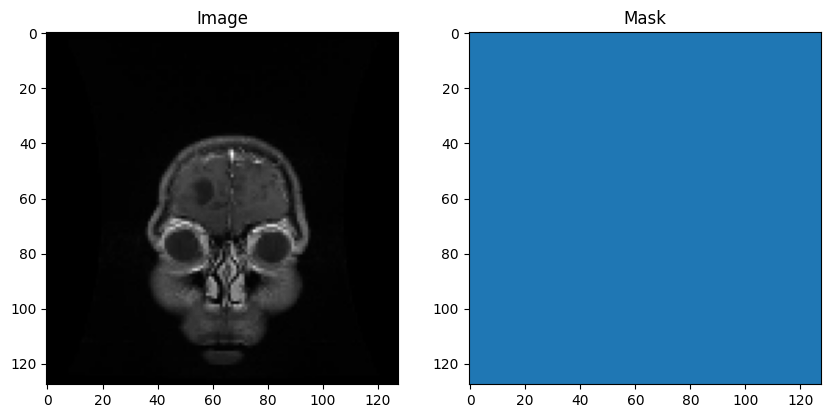

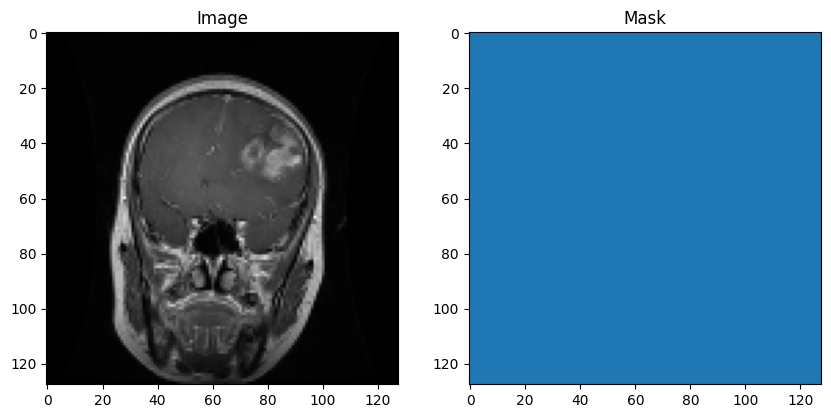

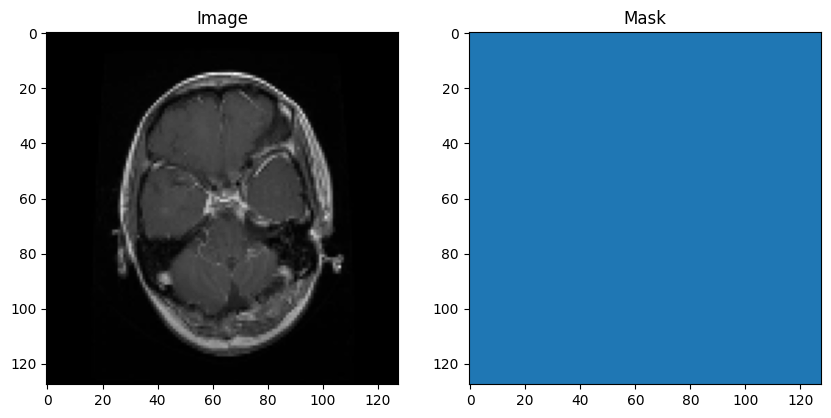

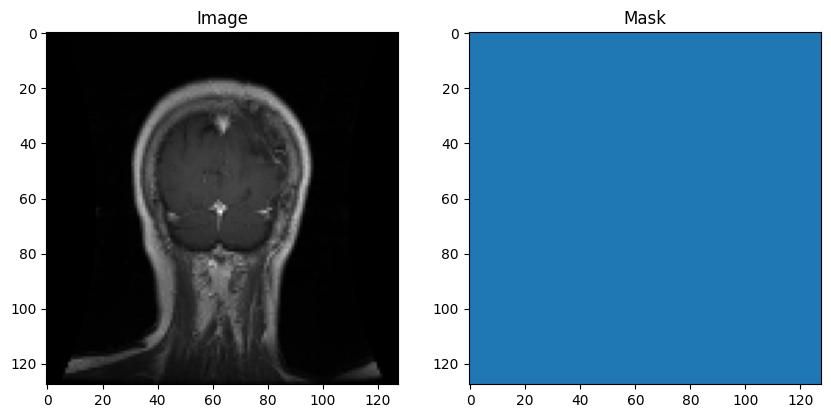

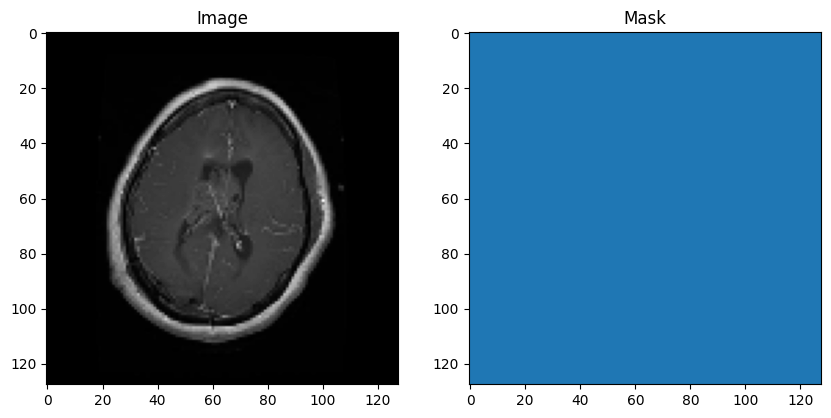

In [41]:
def visualize_samples(images, masks, num_samples=5):
    for i in range(num_samples):
        plt.figure(figsize=(10, 5))

        # عرض الصورة
        plt.subplot(1, 2, 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title("Image")

        # عرض القناع (تحويل One-Hot إذا لزم الأمر)
        plt.subplot(1, 2, 2)
        if masks[i].ndim == 3:  # إذا كان القناع One-Hot
            mask_to_display = np.argmax(masks[i], axis=-1)
        else:  # إذا كان القناع يحتوي على قناة واحدة
            mask_to_display = masks[i]

        # عرض القناع باستخدام 'gray' أو 'tab10' لتوضيح الفئات
        plt.imshow(mask_to_display, cmap='tab10')
        plt.title("Mask")

        plt.show()

# عرض عينات من الصور والأقنعة
visualize_samples(X_train, y_train)



In [31]:
# دالة لتوسيع البيانات باستخدام Albumentations
def augment_image(img):
    transform = A.Compose([
        A.RandomRotate90(),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    ])
    augmented = transform(image=img)['image']
    return augmented

# تطبيق التوسيع على بيانات التدريب
X_train_aug = np.array([augment_image(img.squeeze()) for img in X_train])
X_train_aug = np.expand_dims(X_train_aug, axis=-1)  # إعادة البعد المفقود
y_train_aug = y_train.copy()

# حساب الأوزان للفئات
class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(4), y=y_train.argmax(axis=-1).flatten())
class_weights_dict = {i: class_weights[i] for i in range(4)}

In [32]:
# بناء نموذج U-Net باستخدام Batch Normalization
def unet_model(input_size=(128, 128, 1), num_classes=4):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Dropout(0.2)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Dropout(0.2)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)

    # Decoder
    up4 = UpSampling2D(size=(2, 2))(conv3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)
    conv4 = BatchNormalization()(conv4)

    up5 = UpSampling2D(size=(2, 2))(conv4)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up5)
    conv5 = BatchNormalization()(conv5)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv5)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', dice_coefficient, iou_metric])

    return model

In [33]:
# مقاييس التقييم: Dice و IoU
def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-7) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1e-7)

def iou_metric(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + 1e-7) / (union + 1e-7)

# بناء النموذج
model = unet_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 128, 128, 4)         │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 186,340 (727.89 KB)

 Trainable params: 185,700 (725.39 KB)

 Non-trainable params: 640 (2.50 KB)

In [35]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
history = model.fit(
    X_train_aug, y_train_aug,
    validation_split=0.1,
    epochs=20,
    batch_size=16,
    callbacks=[lr_scheduler]
)



Epoch 1/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 26s 57ms/step - accuracy: 0.3773 - dice_coefficient: 0.3154 - iou_metric: 0.1876 - loss: 1.3260 - val_accuracy: 0.3594 - val_dice_coefficient: 0.4199 - val_iou_metric: 0.2657 - val_loss: 0.8926 - learning_rate: 0.0010
Epoch 2/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.4613 - dice_coefficient: 0.3690 - iou_metric: 0.2266 - loss: 1.1630 - val_accuracy: 0.7848 - val_dice_coefficient: 0.6106 - val_iou_metric: 0.4396 - val_loss: 0.6142 - learning_rate: 0.0010
Epoch 3/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5049 - dice_coefficient: 0.4040 - iou_metric: 0.2536 - loss: 1.0920 - val_accuracy: 0.4924 - val_dice_coefficient: 0.4016 - val_iou_metric: 0.2514 - val_loss: 1.1112 - learning_rate: 0.0010
Epoch 4/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5171 - dice_coefficient: 0.4166 - iou_metric: 0.2637 - loss: 1.0658 - val_accuracy: 0.3832 - val_dice_coefficient: 0.3438 - val_iou_metric: 0.2077 - val_loss:

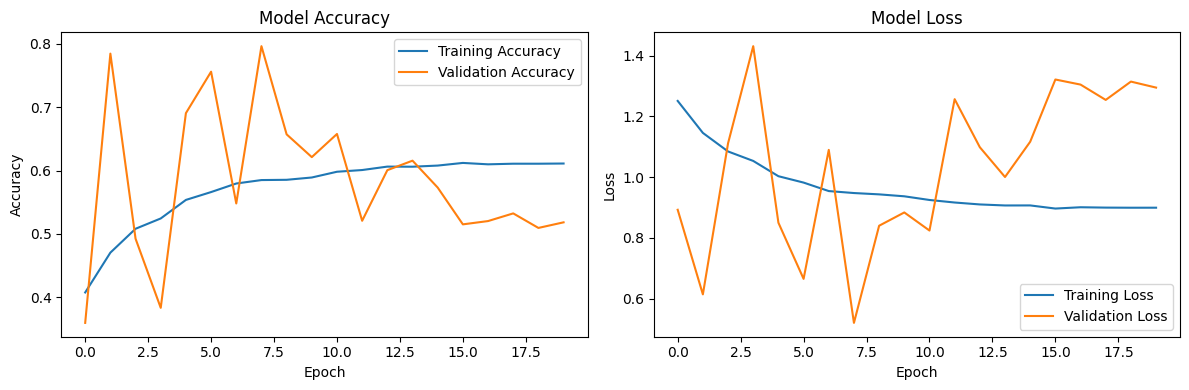

In [36]:
# رسم منحنيات التدريب
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


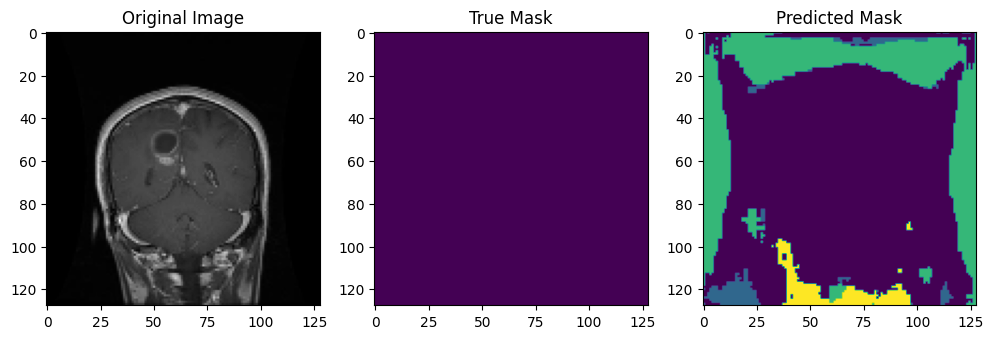

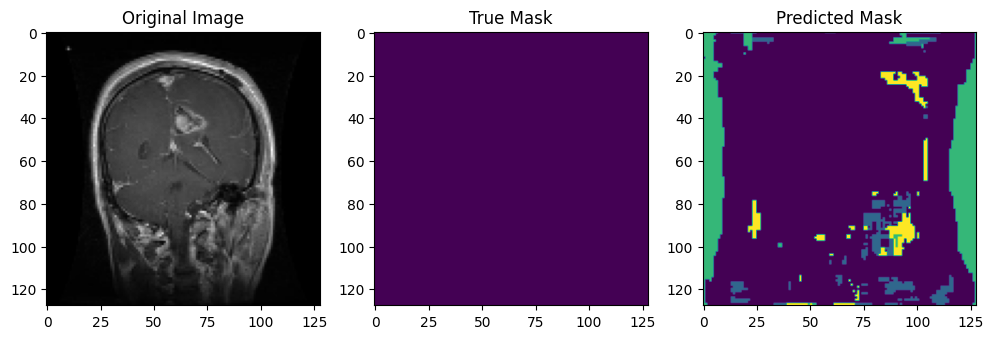

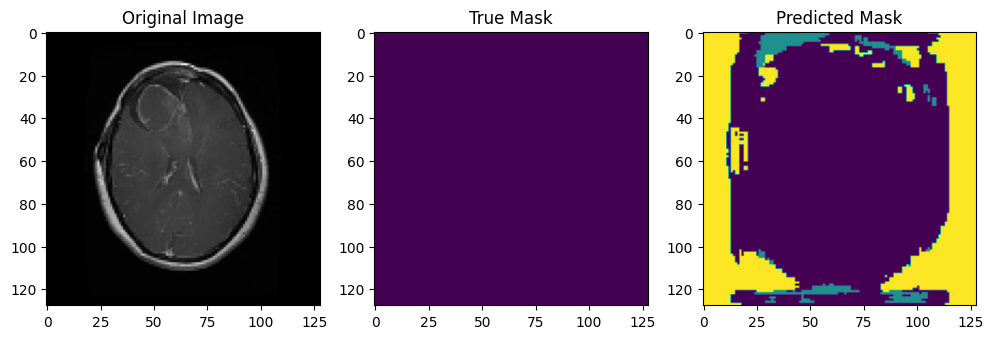

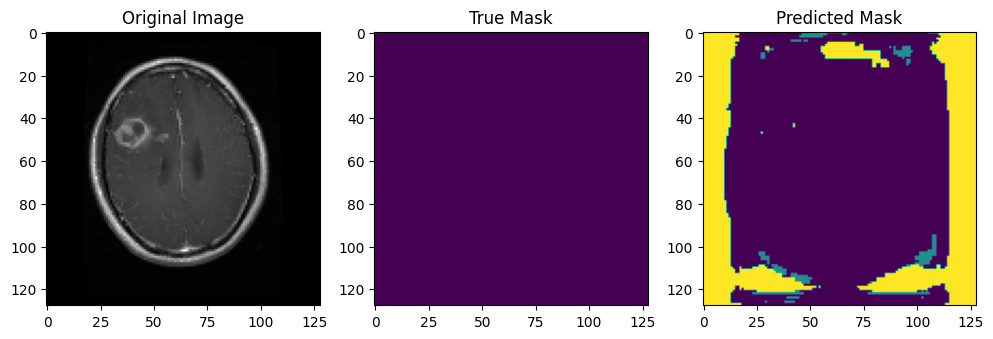

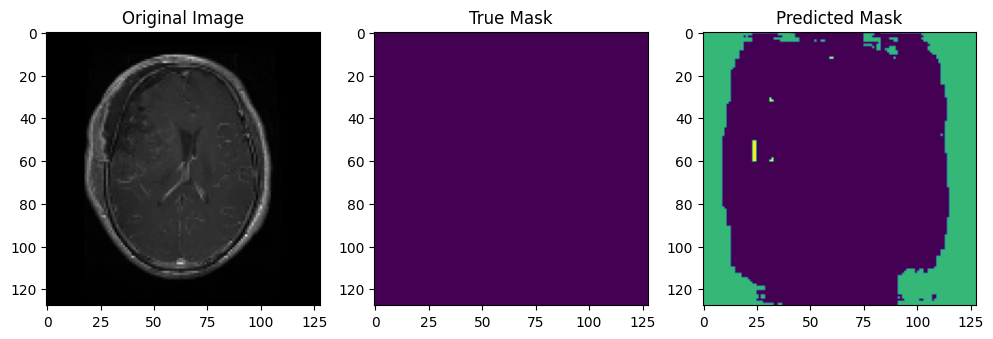

In [37]:
# التنبؤ وعرض النتائج
def predict_and_display(model, X_test, y_test, num_samples=5):
    preds = model.predict(X_test)
    for i in range(num_samples):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(X_test[i].squeeze(), cmap='gray')
        plt.title("Original Image")
        plt.subplot(1, 3, 2)
        plt.imshow(np.argmax(y_test[i], axis=-1), cmap='viridis')
        plt.title("True Mask")
        plt.subplot(1, 3, 3)
        plt.imshow(np.argmax(preds[i], axis=-1), cmap='viridis')
        plt.title("Predicted Mask")
        plt.show()

# اختبار النموذج
predict_and_display(model, X_test, y_test)